In [1]:
import pandas as pd
import numpy as np
from IPython.display import clear_output
import re
import string
import sys
import nltk
import logging
import torch
import pandas as pd
from collections import defaultdict
from rclone_python import rclone
import importlib
import processing_pipelines
importlib.reload(processing_pipelines)
from processing_pipelines import (CleaningPipeline,
                                 Text2SentencePipeline,
                                 MLMPerplexityCalculator,
                                 CLMPerplexityPipeline,
                                 SelectAndrewsVariablesPipeline)



In [2]:
nltk.download('punkt')
nltk.download('treebank')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /home/berstearns/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package treebank to
[nltk_data]     /home/berstearns/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/berstearns/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
print(sys.path)

['/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/home/berstearns/p/garbage_collector/cefr-classifcation/cefr_classification/venv/lib/python3.12/site-packages', '/home/berstearns/p/garbage_collector/cefr-classifcation/cefr_classification/processing_pipelines']


In [4]:
import os
notebook_dir = os.path.abspath("")
local_base_dir = os.path.dirname(notebook_dir)
local_experiment_data_folder = os.path.join(local_base_dir,"datasets", "NLP4CALL_2025_experiment","experiments_data")


def remote_expected(config):
    """
    Check if the configuration expects remote storage for inputs or outputs.
    Returns a tuple:
    - A boolean indicating if remote storage is expected.
    - The remote base directory (if remote storage is expected), otherwise None.
    """
    input_remote = config["storage"]["inputs"]["from"] == "rclone"
    output_remote = config["storage"]["outputs"]["from"] == "rclone"

    # Determine if remote storage is expected
    is_remote = input_remote or output_remote

    # Determine the remote base directory
    remote_base_dir = None
    if input_remote:
        remote_base_dir = config["storage"]["inputs"].get("remote_base_dir")
    if output_remote:
        remote_base_dir = config["storage"]["outputs"].get("remote_base_dir")

    # If both input and output are remote, ensure they have the same base directory
    if input_remote and output_remote:
        input_dir = config["storage"]["inputs"].get("remote_base_dir")
        output_dir = config["storage"]["outputs"].get("remote_base_dir")
        if input_dir != output_dir:
            raise ValueError("Input and output remote base directories must be the same when both are remote.")
    remote_flags = {
        "input": input_remote,
        "output": output_remote,
    }
    return is_remote, remote_base_dir, remote_flags


config_local_local = {
    "storage": {
        "inputs": {
            "from": "local"
        },
        "outputs": {
            "from": "local"
        },
    },
    "text_column": "text",
    "column_mapping": {
        "remainder_efcamdat": {
            "text":"",
            "CEFR":"?"
        },
        "andrew100k": {
            "text": "text",
            "CEFR":"cefr_level"
        }
    },
    "perplexity_models" : [
        "gpt2"
    ],
    "base_columns": ['writing_id', 'cefr_level','text', 'l1' ],
}

config_local_rclone = {
    "storage": {
        "inputs": {
            "from": "local"
        },
        "outputs": {
            "from": "rclone",
            "remote_base_dir": "insight-gdrive:/phd-experimental-data"
        },
    },
    "text_column": "text",
    "column_mapping": {
        "remainder_efcamdat": {
            "text":"",
            "CEFR":"?"
        },
        "andrew100k": {
            "text": "text",
            "CEFR":"cefr_level"
        }
    },
    "perplexity_models" : [
        "gpt2"
    ],
    "base_columns": ['writing_id', 'cefr_level','text', 'l1' ],
}


config = config_local_rclone


is_remoted_expected, remote_base_dir, remote_flags = remote_expected(config)
config["remote_flags"] = remote_flags
if is_remoted_expected:
   remote_experiment_data_folder = os.path.join(remote_base_dir, "NLP4CALL_2025_experiment","experiments_data")


if remote_flags["input"] == False:
    # efcamdat_100k_with_text_and_measures.csv
    efcamdat_100k_fp          = os.path.join(local_experiment_data_folder, "efcamdat_100k_with_text_and_measures.csv")
    efcamdat_100k_train_fp    = os.path.join(local_experiment_data_folder, "efcamdat_train_id.csv")
    efcamdat_100k_test_fp     = os.path.join(local_experiment_data_folder, "efcamdat_test_id.csv")
    vars_present_in_model_fp  = os.path.join(local_experiment_data_folder, "vars_present_in_model.txt")
elif remote_flags["input"] == True:
    # expects a remote + the same folder structure as local folder structure
    # efcamdat_100k_with_text_and_measures.csv
    efcamdat_100k_fp          = os.path.join(remote_experiment_data_folder, "efcamdat_100k_with_text_and_measures.csv")
    efcamdat_100k_train_fp    = os.path.join(remote_experiment_data_folder, "efcamdat_train_id.csv")
    efcamdat_100k_test_fp     = os.path.join(remote_experiment_data_folder, "efcamdat_test_id.csv")
    vars_present_in_model_fp  = os.path.join(remote_experiment_data_folder, "vars_present_in_model.txt")
else:
    raise Exception("unexpected input remote flag")

if remote_flags["output"] == False:
    config["train_output_fp"] =  os.path.join(local_experiment_data_folder, "andrew100k-train-fe.csv")
    config["test_output_fp"] =  os.path.join(local_experiment_data_folder, "andrew100k-test-fe.csv")
elif remote_flags["output"] == True:
    # expects a remote + the same folder structure as local folder structure
    config["train_output_fp"] =  os.path.join(remote_experiment_data_folder, "andrew100k-train-fe.csv")
    config["test_output_fp"] =  os.path.join(remote_experiment_data_folder, "andrew100k-test-fe.csv")
else:
    raise Exception("unexpected output remote flag")

print(efcamdat_100k_fp, config["train_output_fp"])

'''
switch_case = {
    ("local", "local"): handle_local_input_local_output,
    ("local", "rclone"): handle_local_input_rclone_output,
    ("rclone", "local"): handle_rclone_input_local_output,
    ("rclone", "rclone"): handle_rclone_input_rclone_output,
}

# Determine the current configuration
input_type = config["storage"]["inputs"]["from"]
output_type = config["storage"]["outputs"]["from"]

# Use the dictionary to call the appropriate function
if (input_type, output_type) in switch_case:
    vars_present_in_andrews_model = switch_case[(input_type, output_type)]()
else:
    raise ValueError("Invalid input or output storage type in config.")'''

with open(vars_present_in_model_fp) as inpf:
    vars_present_in_andrews_model = [line.strip() for line in inpf]

/home/berstearns/p/garbage_collector/cefr-classifcation/cefr_classification/datasets/NLP4CALL_2025_experiment/experiments_data/efcamdat_100k_with_text_and_measures.csv insight-gdrive:/phd-experimental-data/NLP4CALL_2025_experiment/experiments_data/andrew100k-train-fe.csv


In [5]:
print(len(vars_present_in_andrews_model))

301


## Instantiating Processing Pipelines

In [6]:
SelectAndrewsVariables = SelectAndrewsVariablesPipeline(base_columns=config["base_columns"], selected_variables=vars_present_in_andrews_model)
clean = CleaningPipeline()
text2sentence = Text2SentencePipeline(tokenizer=nltk.tokenize.sent_tokenize)
perplexities_pipelines = defaultdict(int)
for model_name in config["perplexity_models"]:
    perplexities_pipelines[model_name] = CLMPerplexityPipeline(model_name=model_name)

## Loading Files

In [7]:
andrews100kdf = pd.read_csv(efcamdat_100k_fp,index_col=0)
andrews100kdf =  SelectAndrewsVariables(andrews100kdf)
andrews100kdf.columns =  [col.replace("measures.", "measures.andrew.") for col in andrews100kdf.columns]
andrews100ktrainids = pd.read_csv(efcamdat_100k_train_fp)['writing_id']
andrews100ktestids = pd.read_csv(efcamdat_100k_test_fp)['writing_id']

[17:03:57] WARNING  The following columns are not in the DataFrame and will be ignored: {'corpus',  ]8;id=198038;file:///home/berstearns/p/garbage_collector/cefr-classifcation/cefr_classification/processing_pipelines/processing_pipelines/__init__.py\__init__.py]8;;\:]8;id=222739;file:///home/berstearns/p/garbage_collector/cefr-classifcation/cefr_classification/processing_pipelines/processing_pipelines/__init__.py#246\246]8;;\
                    'measures.counts.acl.relcl', 'measures.counts.acl.relcl_ratio'}                                

In [8]:
andrew100ktrain_df = pd.merge(andrews100kdf,andrews100ktrainids,on="writing_id")
andrew100ktest_df = pd.merge(andrews100kdf,andrews100ktestids,on="writing_id")#.sample(1000)

In [9]:
andrews100kdf.columns

Index(['writing_id', 'cefr_level', 'text', 'l1',
       'measures.andrew.collocations.text_level.ratio_num_token',
       'measures.andrew.collocations.text_level.ttr',
       'measures.andrew.counts.acl', 'measures.andrew.counts.acl_ratio',
       'measures.andrew.counts.ADJ', 'measures.andrew.counts.ADJ_ratio',
       ...
       'measures.andrew.taassc.L2SCA.CP_C',
       'measures.andrew.taassc.L2SCA.CP_T',
       'measures.andrew.taassc.L2SCA.CT_T',
       'measures.andrew.taassc.L2SCA.DC_C',
       'measures.andrew.taassc.L2SCA.DC_T', 'measures.andrew.taassc.L2SCA.MLC',
       'measures.andrew.taassc.L2SCA.MLS', 'measures.andrew.taassc.L2SCA.MLT',
       'measures.andrew.taassc.L2SCA.T_S',
       'measures.andrew.taassc.L2SCA.VP_T'],
      dtype='object', length=302)

In [17]:
idx_to_class_ = lambda v: {
         0: "A1",
         1: "A2",
         2: "B1",
         3: "B2",
         4: "C1",
         5: "C1",
}.get(v, None)
label_to_idx_ = lambda v: {
         "A1": 0,
         "A2": 1,
         "B1": 2,
         "B2": 3,
         "C1": 4,
         "C2": 4,
}.get(v, None)


In [29]:

for df_name, target_df in [
                ("andrew100ktest_df",andrew100ktest_df),
                ("andrew100ktrain_df",andrew100ktrain_df),
                # ("remainder",remainder_efcamdat_df),
                 ]:  
    ds_split =  {
        "andrew100ktest_df": "test",
        "andrew100ktrain_df": "train",
        "remainder": "remainder",
    }.get(df_name)
    ds_name =  {
        "andrew100ktest_df": "andrew100k",
        "andrew100ktrain_df": "andrew100k",
        "remainder": "remainder",
    }.get(df_name)
    print(df_name)
    target_df["cleaned_text"] = clean(target_df, column_name=config["column_mapping"][ds_name]["text"])[config["column_mapping"][ds_name]["text"]]
    target_df["sentences"] = text2sentence(target_df, column_name="cleaned_text")
    target_df["measures.basic.n_sentences"] = target_df["sentences"].apply(lambda x: len(x))
    target_df["tokens_per_sentence"] =target_df["sentences"].apply(lambda lst: [nltk.tokenize.word_tokenize(sent) for sent in lst])
    target_df["measures.basic.total_n_tokens"] = target_df["tokens_per_sentence"].apply(lambda lst_lst: sum([len(sent_lst) for sent_lst in lst_lst]))
    target_df["measures.basic.avg_n_tokens_per_sentence"] = target_df.apply(lambda x: x["measures.basic.total_n_tokens"]/x["measures.basic.n_sentences"],axis=1)
    output_fp = config[f"{ds_split}_output_fp"]
    output_fn = output_fp.split(os.sep)[-1]
    if config["remote_flags"]["output"]:
        tmp_fp = os.path.join(notebook_dir, output_fn)
        target_df.to_csv(tmp_fp,index=False)
        rclone.copy(tmp_fp, output_fp)
    else:
        target_df.to_csv(output_fp, index=False)
    #for model_name, perplexity_pipeline in perplexities_pipelines.items():
    #    target_df[f"measures.perplexity.wholetext.{modelname}"] = perplexity_pipeline(target_df, text_column="cleaned_text")


andrew100ktest_df


Output()

andrew100ktrain_df


Output()

In [31]:
dir(rclone)

['Callable',
 'Dict',
 'HashTypes',
 'List',
 'Optional',
 'RemoteTypes',
 'Tuple',
 'Union',
 '__builtins__',
 '__cached__',
 '__check_installed',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '__warningregistry__',
 '_rclone_transfer_operation',
 'about',
 'cat',
 'check_remote_existing',
 'copy',
 'copyto',
 'create_remote',
 'delete',
 'get_remotes',
 'hash',
 'is_installed',
 'json',
 'link',
 'logger',
 'ls',
 'mkdir',
 'move',
 'moveto',
 'purge',
 're',
 'set_log_level',
 'size',
 'sync',
 'tree',
 'utils',
 'version',
 'which',
 'wraps']

In [27]:
output_fn = output_fp.split(os.sep)[-1]
print(output_fn)

andrew100k-test-fe.csv


<Axes: >

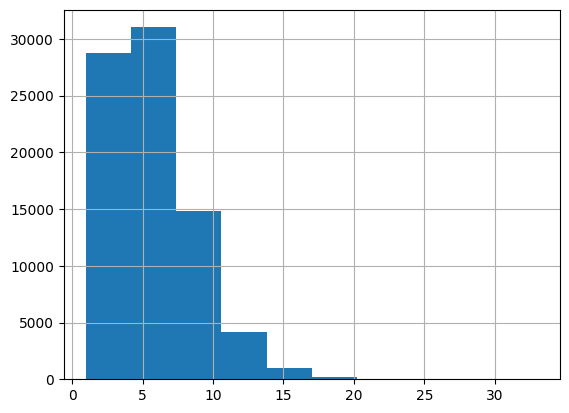

In [37]:
andrew100ktrain_df["n_sentences"].hist()

<Axes: >

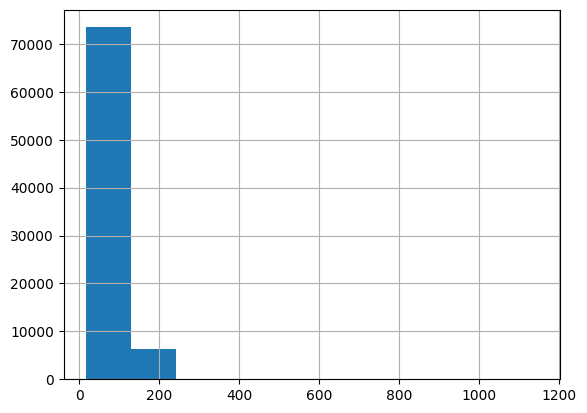

In [38]:
andrew100ktrain_df["total_n_tokens"].hist()

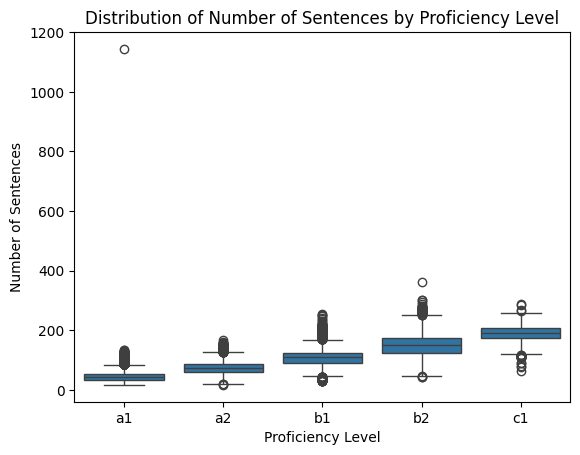

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
# Define the desired order of proficiency levels
proficiency_order = ["A1", "A2", "B1", "B2", "C1"]#, "C2"]

# Create the boxplot with the specified order
sns.boxplot(x=config["CEFR_column"], y='total_n_tokens', data=andrew100ktrain_df
            , order=[v.lower() for v in proficiency_order])
plt.xlabel('Proficiency Level')
plt.ylabel('Number of Sentences')
plt.title('Distribution of Number of Sentences by Proficiency Level')
plt.show()

['being in a earth sciences domain at the beginning of the year my class and i went to a little city called paris un the south of paris.',
 'after a few classes of cartographic basics it was time for us to do it in real life to see what it is like to be on the field.',
 'the aim of this trip was to recognize a couple of series of rock and identify which ones belongs to which period of the earth time.',
 'and then being able to report everything we saw on a map and create a geological map of a place weve never been before.',
 'for 10 days we had to wake up every morning a 7 to be ready at 8 to walk through the fauna and flora climbing mountains against the wind or the sun or the rain and walk around 5 to 10 kilometers per day until 6pm.',
 'the field was around 12m2 and rocks we studied about were sedimentary.',
 'all of us geosciences students were separate into little groups of 2 people.',
 'my partner and i were watching out and paying attention to all the rocks around us.',
 'when t

In [52]:
import spacy

# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")

# Process whole documents
text = df["cleaned_text"][0]
doc = nlp(text)

# Analyze syntax
print("Noun phrases:", [chunk.text for chunk in doc.noun_chunks])
print("Verbs:", [token.lemma_ for token in doc if token.pos_ == "VERB"])

# Find named entities, phrases and concepts
for entity in doc.ents:
    print(entity.text, entity.label_)
sents = [s for s in doc.sents]
print(dir(doc))
print(f"text:\n {text}","\n\n")
print(f"sent: {sents[0:3]}")

text:
 being in a earth sciences domain at the beginning of the year my class and i went to a little city called paris un the south of paris. after a few classes of cartographic basics it was time for us to do it in real life to see what it is like to be on the field. the aim of this trip was to recognize a couple of series of rock and identify which ones belongs to which period of the earth time. and then being able to report everything we saw on a map and create a geological map of a place weve never been before. for 10 days we had to wake up every morning a 7 to be ready at 8 to walk through the fauna and flora climbing mountains against the wind or the sun or the rain and walk around 5 to 10 kilometers per day until 6pm. the field was around 12m2 and rocks we studied about were sedimentary. all of us geosciences students were separate into little groups of 2 people. my partner and i were watching out and paying attention to all the rocks around us. when there is a in place serie we

In [4]:
df.describe()

,nb_annees_L2,Sejours_duree_semaines,Sejours_frequence,Lang_exposition,Section_renforcee
count,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000
mean,9.495694,3.543541,2.027751,5.623541,0.371292
std,2.498128,17.252610,14.857374,9.175903,0.483382
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,0.000000,0.000000,1.000000,0.000000
50%,10.000000,1.000000,1.000000,3.000000,0.000000
75%,11.000000,3.000000,2.000000,6.000000,1.000000
max,22.000000,420.000000,360.000000,120.000000,1.000000


In [5]:
df.describe(include="object")

,pseudo,Voc_range,CECRL,L1,Domaine_de_specialite,L2,Note_dialang_ecrit,Lecture_regularite,autre_langue,tache_ecrit,Texte_etudiant,Date_ajout
count,1045,1015,1045,1045,1045,1045,673,992,610,1045,1045,1045
unique,1015,6,6,14,12,1,6,4,8,3,1013,505
top,1f2dd72bc867a07a8a11579ddd2345b3d9851622289c5c...,B1,B1,French,Information Communication,Anglais,B1,hebdomadaire,Espagnol,Tache_1,I did'nt know what to do in my life until the ...,2022-09-14 14:43:00
freq,2,374,358,999,408,1045,263,262,306,664,2,24


In [6]:
df["CECRL"].value_counts()

CECRL
B1    358
A2    324
B2    212
A1     90
C1     53
C2      8
Name: count, dtype: int64

In [7]:
df.isnull().sum()

pseudo                      0
Voc_range                  30
CECRL                       0
nb_annees_L2                0
L1                          0
Domaine_de_specialite       0
Sejours_duree_semaines      0
Sejours_frequence           0
Lang_exposition             0
L2                          0
Note_dialang_ecrit        372
Lecture_regularite         53
autre_langue              435
tache_ecrit                 0
Texte_etudiant              0
Date_ajout                  0
Section_renforcee           0
dtype: int64

In [8]:
df["L1"].value_counts()/len(df["L1"])

L1
French                  0.955981
Arabic                  0.014354
Other                   0.008612
English                 0.004785
Vietnamese              0.003828
Turkish                 0.001914
Malagasy                0.001914
English##Gan Chinese    0.001914
Spanish                 0.001914
Italian                 0.000957
French##Spanish         0.000957
Mandarin                0.000957
Amharic                 0.000957
Russian                 0.000957
Name: count, dtype: float64

In [9]:
map_ = {
    c: " " for c in string.whitespace
}
replaces_ = {
    
    "...":"",
    "..": "",
}
specials = string.whitespace + ".()"
print(specials)
texts = df["Texte_etudiant"].apply(lambda x: "".join([map_.get(ch.lower(),ch.lower()) for ch in x if ch.isalnum() or ch in specials]))
texts = texts.apply(lambda x: re.sub(r'\.{2,}', '', x))
texts = texts.apply(lambda x: re.sub(r' {2,}', '', x))

 	
.()


In [10]:
import string
dir(string)

['Formatter',
 'Template',
 '_ChainMap',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_re',
 '_sentinel_dict',
 '_string',
 'ascii_letters',
 'ascii_lowercase',
 'ascii_uppercase',
 'capwords',
 'digits',
 'hexdigits',
 'octdigits',
 'printable',
 'punctuation',
 'whitespace']

In [11]:
string.ascii_letters

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [12]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [13]:
char_ = "!#"

In [14]:
char_.isalnum()

False

In [15]:
dir(string)

['Formatter',
 'Template',
 '_ChainMap',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_re',
 '_sentinel_dict',
 '_string',
 'ascii_letters',
 'ascii_lowercase',
 'ascii_uppercase',
 'capwords',
 'digits',
 'hexdigits',
 'octdigits',
 'printable',
 'punctuation',
 'whitespace']

In [16]:
for t in texts:
    print(t.split("."))
    input()

['being in a earth sciences domain at the beginning of the year my class and i went to a little city called paris un the south of paris', ' after a few classes of cartographic basics it was time for us to do it in real life to see what it is like to be on the field', 'the aim of this trip was to recognize a couple of series of rock and identify which ones belongs to which period of the earth time', ' and then being able to report everything we saw on a map and create a geological map of a place weve never been before', 'for 10 days we had to wake up every morning a 7 to be ready at 8 to walk through the fauna and flora climbing mountains against the wind or the sun or the rain and walk around 5 to 10 kilometers per day until 6pm', ' the field was around 12m2 and rocks we studied about were sedimentary', 'all of us geosciences students were separate into little groups of 2 people', ' my partner and i were watching out and paying attention to all the rocks around us', ' when there is ain

KeyboardInterrupt: Interrupted by user

In [21]:

a="d f\nd"

In [22]:
[map_.get(c, c) for c in a]

['d', ' ', 'f', ' ', 'd']

In [23]:
a="... . .. .. ....... . ......."

In [24]:
for p,r in replaces_.items():
    a = a.replace(p,r)

In [25]:
a

' .   . . .'

In [26]:
import re

a = "... . .. .. ....... . ......."

# Replace occurrences of more than one dot with a single dot
result = re.sub(r'\.{2,}', '', a)

print(result)

 .    . 


In [27]:
texts.apply(lambda x: x.split("."))[0]

['being in a earth sciences domain at the beginning of the year my class and i went to a little city called paris un the south of paris',
 ' after a few classes of cartographic basics it was time for us to do it in real life to see what it is like to be on the field',
 'the aim of this trip was to recognize a couple of series of rock and identify which ones belongs to which period of the earth time',
 ' and then being able to report everything we saw on a map and create a geological map of a place weve never been before',
 'for 10 days we had to wake up every morning a 7 to be ready at 8 to walk through the fauna and flora climbing mountains against the wind or the sun or the rain and walk around 5 to 10 kilometers per day until 6pm',
 ' the field was around 12m2 and rocks we studied about were sedimentary',
 'all of us geosciences students were separate into little groups of 2 people',
 ' my partner and i were watching out and paying attention to all the rocks around us',
 ' when ther

In [28]:
df["Texte_etudiant"][0]

"Being in a earth sciences domain, at the beginning of the year my class and I went to a little city called Paris un the south of Paris. After a few classes of cartographic basics, it was time for us to do it in real life, to see what it is like to be on the field.\n The aim of this trip was to recognize a couple of series of rock, and identify which ones belongs to which period of the earth time. And then, being able to report everything we saw on a map, and create a geological map of a place we've never been before.\n For 10 days, we had to wake up every morning a 7 to be ready at 8 to walk through the fauna and flora, climbing mountains, against the wind or the sun or the rain, and walk around 5 to 10 kilometers per day, until 6pm. The field was around 12m^2 and rocks we studied about were sedimentary.\n All of us, geosciences students, were separate into little groups of 2 people. My partner and I were watching out and paying attention to all the rocks around us. When there is a « 

## 

## Perplexity

In [45]:

# Sample DataFrame
data = {
    "text": [
        "This is a sample sentence.",
        "Language models are fascinating.",
        "Perplexity measures how well a model predicts a sequence."
    ]
}
df = pd.DataFrame(data)

# Initialize the perplexity calculator with a specific model
perplexity_calculator = PerplexityCalculator(model_name="gpt2")  # Can replace "gpt2" with any model name

# Use the __call__ method to calculate perplexity for a single text
single_text = "This is a test sentence."
perplexity_score = perplexity_calculator(single_text)
print(f"Perplexity for single text: {perplexity_score}")

# Use the __call__ method to calculate perplexity for a DataFrame column
perplexity_scores = perplexity_calculator(df, text_column="text")
df["perplexity"] = perplexity_scores
print(df)


Perplexity for single text: 86.48322296142578
                                                text  perplexity
0                         This is a sample sentence.   71.438499
1                   Language models are fascinating.  198.041183
2  Perplexity measures how well a model predicts ...   92.741776


# 